In [1]:
#Importing the basic librarires

import os
import math
import numpy as np
import pandas as pd
import seaborn as sns
from IPython.display import display

#from brokenaxes import brokenaxes
from statsmodels.formula import api
from sklearn.feature_selection import RFE
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from statsmodels.stats.outliers_influence import variance_inflation_factor

from sklearn.decomposition import PCA
from sklearn.linear_model import Ridge
from sklearn.linear_model import Lasso
from sklearn.linear_model import ElasticNet
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import PolynomialFeatures
from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error

import matplotlib.pyplot as plt
plt.rcParams['figure.figsize'] = [10,6]

import warnings 
warnings.filterwarnings('ignore')

In [5]:
#Importing the dataset

df = pd.read_csv('Walmart.csv')

#df.drop(['car name'], axis=1, inplace=True)
display(df.head())

original_df = df.copy(deep=True)

print('\n\033[1mInference:\033[0m The Datset consists of {} features & {} samples.'.format(df.shape[1], df.shape[0]))

,Store,Date,Weekly_Sales,Holiday_Flag,Temperature,Fuel_Price,CPI,Unemployment
0,1,05-02-2010,1643690.90,0,42.31,2.572,211.096358,8.106
1,1,12-02-2010,1641957.44,1,38.51,2.548,211.242170,8.106
2,1,19-02-2010,1611968.17,0,39.93,2.514,211.289143,8.106
3,1,26-02-2010,1409727.59,0,46.63,2.561,211.319643,8.106
4,1,05-03-2010,1554806.68,0,46.50,2.625,211.350143,8.106



Inference: The Datset consists of 8 features & 6435 samples.


### Feature Engineering: Date Adjustment for Weekly Sales Data



Since the dataset records **weekly sales ending on a given date**, we first subtract 7 days from each date to align it with the actual start of the sales week. This ensures that any features derived from the date (such as month, year, or week-of-month) accurately reflect the period in which the sales occurred, rather than the week’s end.

After adjusting the date:

- We extract the **year** and **month** from the shifted date.

- We calculate the **week-of-month** by dividing the day of the month by 7 (integer division) and adding 1, then collapsing any values above 4 into 4 for consistent bucketing.

This approach helps capture seasonal and calendar effects more accurately in regression and forecasting models.

In [6]:
# Feature engineering: Add Year, Month, Week-of-Month to DataFrame (no one-hot encoding, keep all columns except Date)
import numpy as np
from pandas.api.types import CategoricalDtype

# Ensure Date is parsed correctly (dayfirst=True for Walmart.csv)
df["Date"] = pd.to_datetime(df["Date"], dayfirst=True, errors="raise")

# Go back 7 days from the given date
date_adj = df["Date"] - pd.Timedelta(days=7)

# Add new columns to the DataFrame
df["year"]  = date_adj.dt.year.astype("int16")
df["month"] = date_adj.dt.month.astype("int8")
month_start = date_adj - pd.to_timedelta(date_adj.dt.day - 1, unit="D")
wom_raw = ((date_adj - month_start).dt.days // 7 + 1)
df["week_of_month"] = np.minimum(wom_raw, 4).astype("int8")
wom_type = CategoricalDtype(categories=[1,2,3,4], ordered=True)
df["week_of_month"] = df["week_of_month"].astype(wom_type)

# Drop the original Date column
df.drop(columns=["Date"], inplace=True)

# Display the updated DataFrame with new columns (first 5 rows)
display(df.head())

,Store,Weekly_Sales,Holiday_Flag,Temperature,Fuel_Price,CPI,Unemployment,year,month,week_of_month
0,1,1643690.90,0,42.31,2.572,211.096358,8.106,2010,1,4
1,1,1641957.44,1,38.51,2.548,211.242170,8.106,2010,2,1
2,1,1611968.17,0,39.93,2.514,211.289143,8.106,2010,2,2
3,1,1409727.59,0,46.63,2.561,211.319643,8.106,2010,2,3
4,1,1554806.68,0,46.50,2.625,211.350143,8.106,2010,2,4


In [8]:
#Checking the dtypes of all the columns

df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6435 entries, 0 to 6434
Data columns (total 10 columns):
 #   Column         Non-Null Count  Dtype   
---  ------         --------------  -----   
 0   Store          6435 non-null   int64   
 1   Weekly_Sales   6435 non-null   float64 
 2   Holiday_Flag   6435 non-null   int64   
 3   Temperature    6435 non-null   float64 
 4   Fuel_Price     6435 non-null   float64 
 5   CPI            6435 non-null   float64 
 6   Unemployment   6435 non-null   float64 
 7   year           6435 non-null   int16   
 8   month          6435 non-null   int8    
 9   week_of_month  6435 non-null   category
dtypes: category(1), float64(5), int16(1), int64(2), int8(1)
memory usage: 377.4 KB


In [9]:
df.nunique().sort_values()

Holiday_Flag        2
year                3
week_of_month       4
month              12
Store              45
Unemployment      349
Fuel_Price        892
CPI              2145
Temperature      3528
Weekly_Sales     6435
dtype: int64

In [10]:
# Display statistical summary of the DataFrame
display(df.describe())

,Store,Weekly_Sales,Holiday_Flag,Temperature,Fuel_Price,CPI,Unemployment,year,month
count,6435.000000,6.435000e+03,6435.000000,6435.000000,6435.000000,6435.000000,6435.000000,6435.000000,6435.000000
mean,23.000000,1.046965e+06,0.069930,60.663782,3.358607,171.578394,7.999151,2010.951049,6.384615
std,12.988182,5.643666e+05,0.255049,18.444933,0.459020,39.356712,1.875885,0.796283,3.256067
min,1.000000,2.099862e+05,0.000000,-2.060000,2.472000,126.064000,3.879000,2010.000000,1.000000
25%,12.000000,5.533501e+05,0.000000,47.460000,2.933000,131.735000,6.891000,2010.000000,4.000000
50%,23.000000,9.607460e+05,0.000000,62.670000,3.445000,182.616521,7.874000,2011.000000,6.000000
75%,34.000000,1.420159e+06,0.000000,74.940000,3.735000,212.743293,8.622000,2012.000000,9.000000
max,45.000000,3.818686e+06,1.000000,100.140000,4.468000,227.232807,14.313000,2012.000000,12.000000


In [11]:
# Define categorical and continuous columns
categorical_cols = ['Holiday_Flag', 'year', 'week_of_month', 'month', 'Store']
continuous_cols = [col for col in df.columns if col not in categorical_cols]

print('Categorical columns:', categorical_cols)
print('Continuous columns:', continuous_cols)

Categorical columns: ['Holiday_Flag', 'year', 'week_of_month', 'month', 'Store']
Continuous columns: ['Weekly_Sales', 'Temperature', 'Fuel_Price', 'CPI', 'Unemployment']


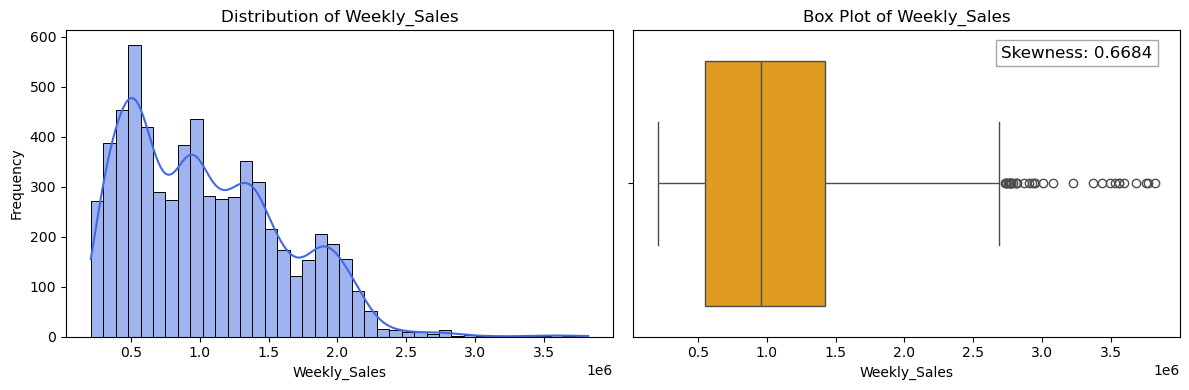

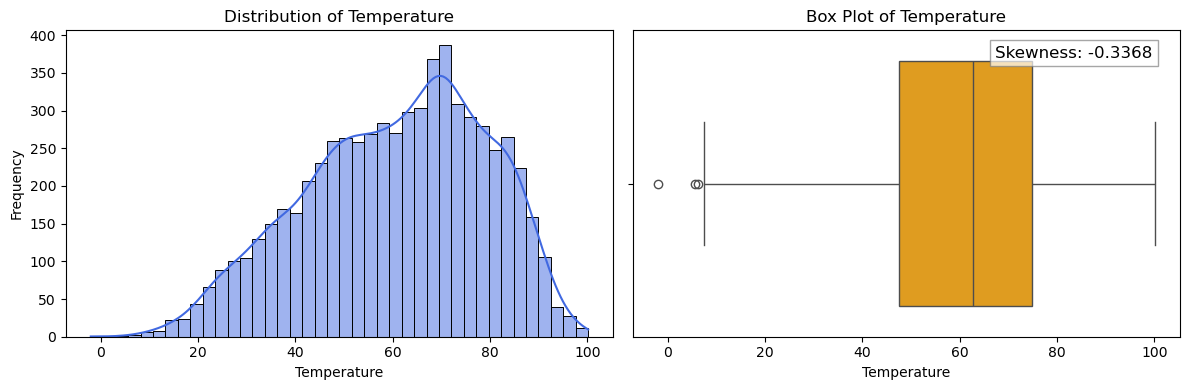

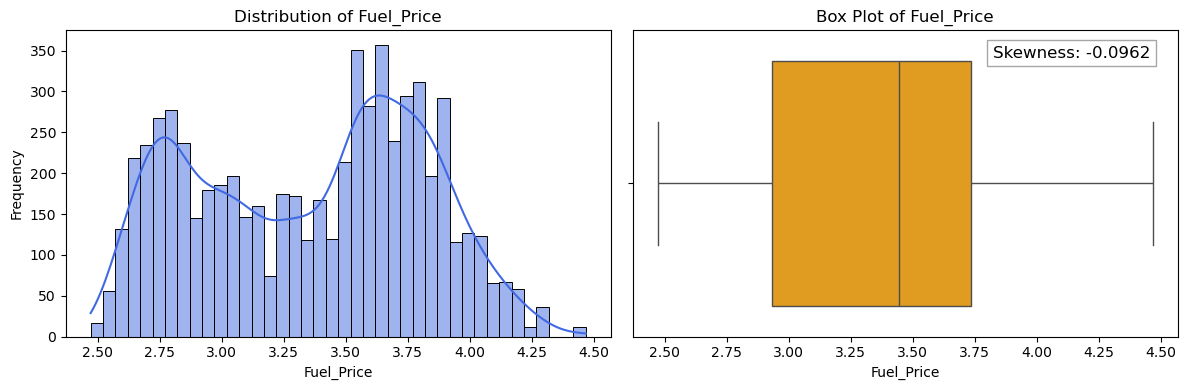

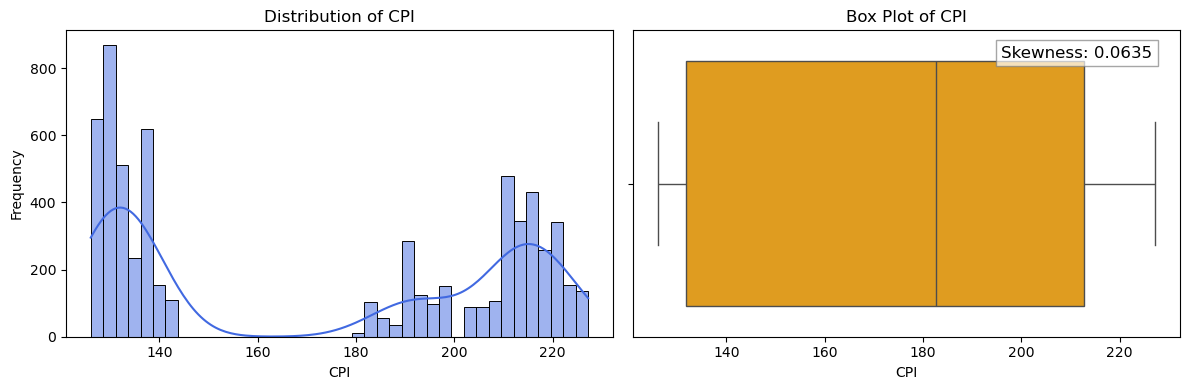

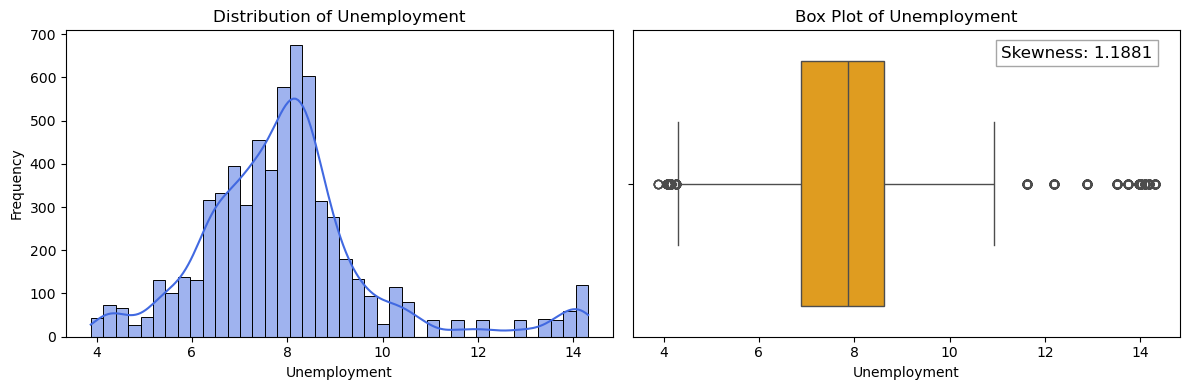

In [12]:
# Plot distribution and box plots for all continuous variables, with skewness
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import skew

for col in continuous_cols:
    fig, axs = plt.subplots(1, 2, figsize=(12, 4))
    # Distribution plot
    sns.histplot(df[col], bins=40, kde=True, ax=axs[0], color='royalblue')
    axs[0].set_title(f'Distribution of {col}')
    axs[0].set_xlabel(col)
    axs[0].set_ylabel('Frequency')
    # Box plot
    sns.boxplot(x=df[col], ax=axs[1], color='orange')
    axs[1].set_title(f'Box Plot of {col}')
    axs[1].set_xlabel(col)
    # Skewness
    sk = skew(df[col].dropna(), bias=False)
    axs[1].text(0.95, 0.95, f'Skewness: {sk:.4f}', transform=axs[1].transAxes, fontsize=12, ha='right', va='top', bbox=dict(facecolor='white', alpha=0.7, edgecolor='gray'))
    plt.tight_layout()
    plt.show()

In [13]:
# Check for outlier count and percentage for all continuous variables using IQR method
for col in continuous_cols:
    Q1 = df[col].quantile(0.25)
    Q3 = df[col].quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    outliers = df[(df[col] < lower_bound) | (df[col] > upper_bound)]
    num_outliers = outliers.shape[0]
    total = df.shape[0]
    percent_outliers = (num_outliers / total) * 100
    print(f'{col}: Outliers = {num_outliers}, Percentage = {percent_outliers:.2f}%')

Weekly_Sales: Outliers = 34, Percentage = 0.53%
Temperature: Outliers = 3, Percentage = 0.05%
Fuel_Price: Outliers = 0, Percentage = 0.00%
CPI: Outliers = 0, Percentage = 0.00%
Unemployment: Outliers = 481, Percentage = 7.47%


In [14]:
# Trim 'Unemployment' values below 5 and above 12
df = df[(df['Unemployment'] >= 5) & (df['Unemployment'] <= 12)]
print(f"Data shape after trimming Unemployment: {df.shape}")

Data shape after trimming Unemployment: (5883, 10)


In [15]:
# Calculate % outliers and skewness for 'Unemployment' and 'Weekly_Sales'
from scipy.stats import skew

for col in ['Unemployment', 'Weekly_Sales']:
    Q1 = df[col].quantile(0.25)
    Q3 = df[col].quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    outliers = df[(df[col] < lower_bound) | (df[col] > upper_bound)]
    num_outliers = outliers.shape[0]
    total = df.shape[0]
    percent_outliers = (num_outliers / total) * 100 if total > 0 else 0
    sk = skew(df[col].dropna(), bias=False) if total > 0 else float('nan')
    print(f"{col}: % Outliers = {percent_outliers:.2f}%, Skewness = {sk:.4f}")

Unemployment: % Outliers = 1.33%, Skewness = 0.2317
Weekly_Sales: % Outliers = 0.51%, Skewness = 0.6908


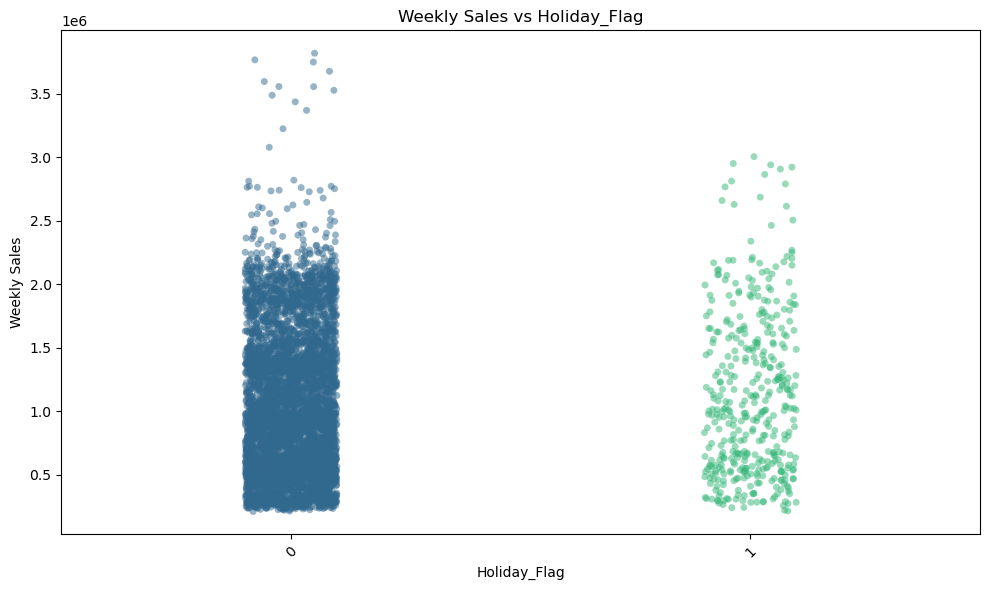

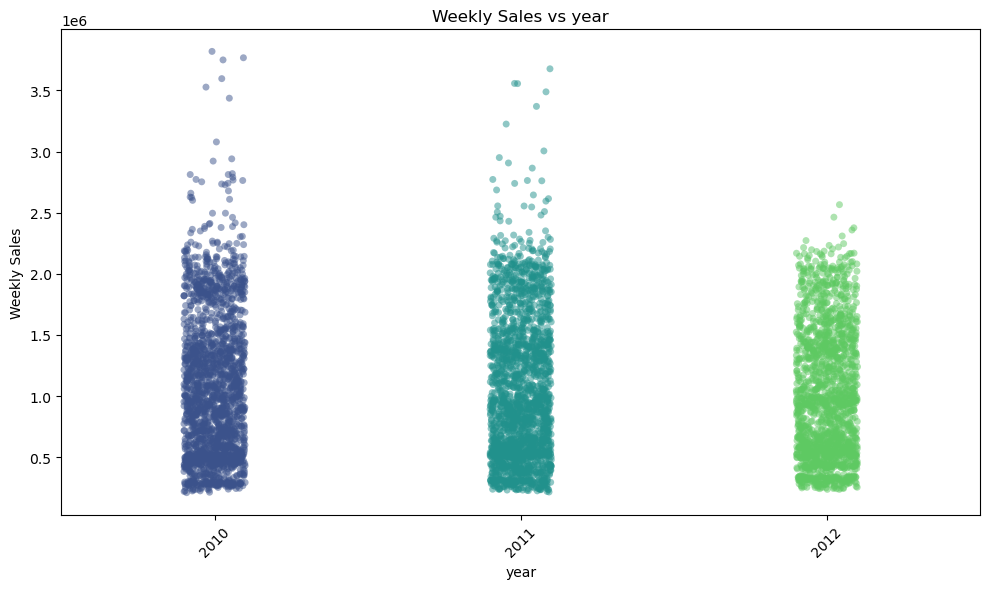

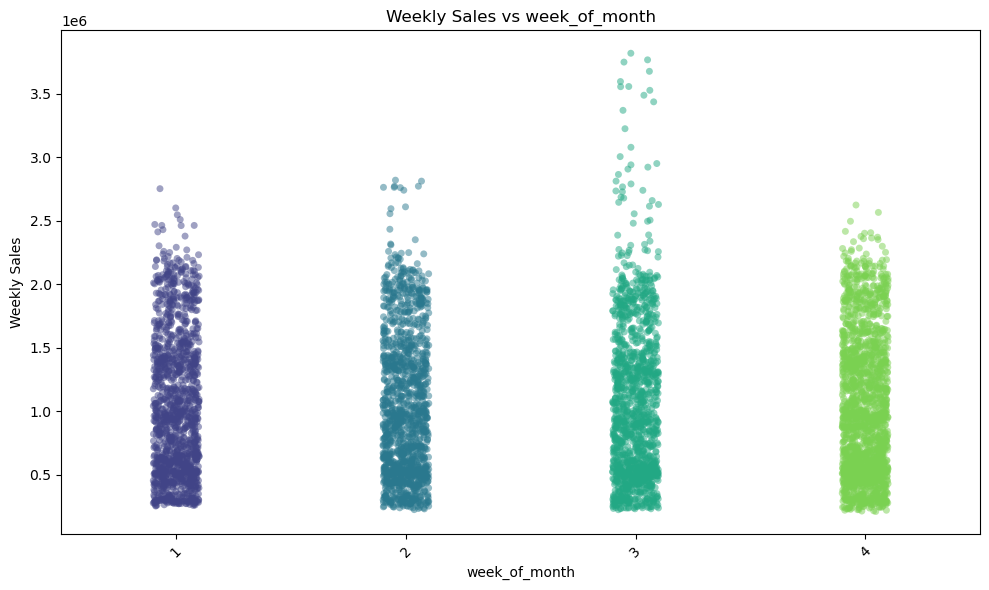

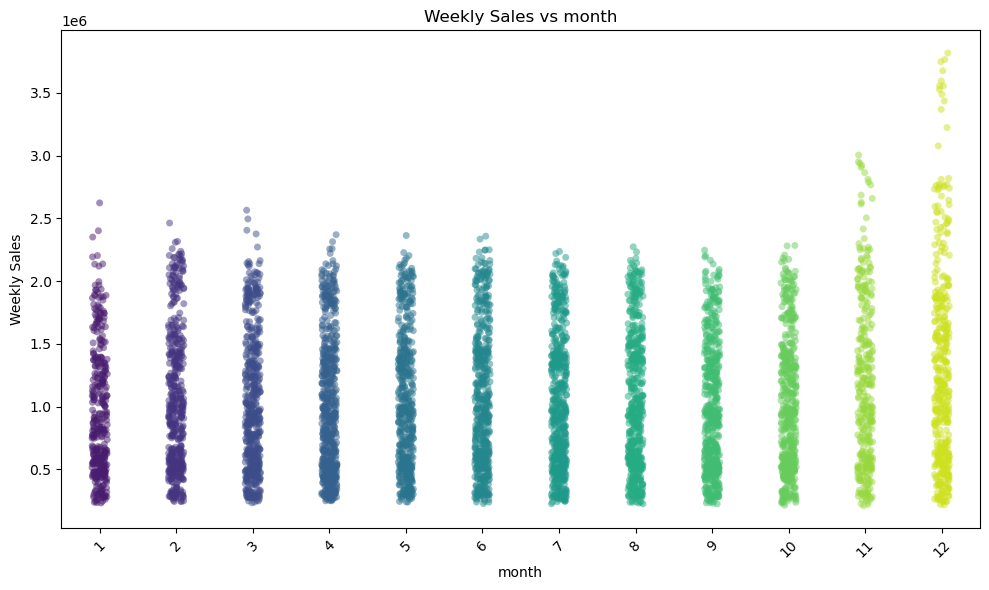

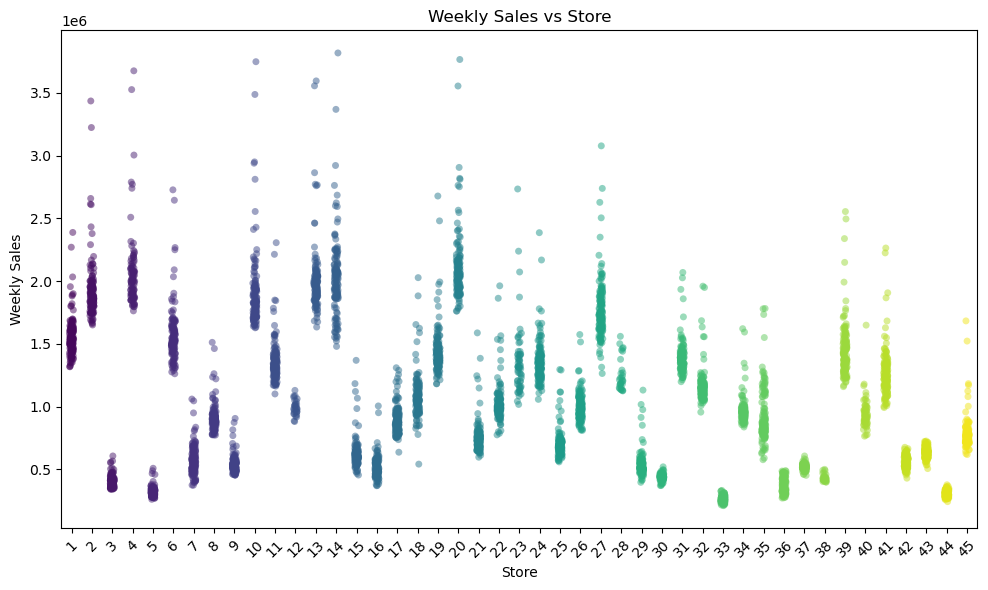

In [16]:
# Scatter plot: categorical variable (x) vs target (y)
import seaborn as sns
import matplotlib.pyplot as plt

for cat in categorical_cols:
    plt.figure(figsize=(10, 6))
    sns.stripplot(x=cat, y='Weekly_Sales', data=df, jitter=True, alpha=0.5, palette='viridis')
    plt.title(f'Weekly Sales vs {cat}')
    plt.xlabel(cat)
    plt.ylabel('Weekly Sales')
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()

In [17]:
# One-hot encode all categorical variables
df_encoded = pd.get_dummies(df, columns=categorical_cols, drop_first=True)
print(f"Shape after one-hot encoding: {df_encoded.shape}")
df_encoded.head()

Shape after one-hot encoding: (5883, 66)


,Weekly_Sales,Temperature,Fuel_Price,CPI,Unemployment,Holiday_Flag_1,year_2011,year_2012,week_of_month_2,week_of_month_3,...,Store_36,Store_37,Store_38,Store_39,Store_40,Store_41,Store_42,Store_43,Store_44,Store_45
0,1643690.90,42.31,2.572,211.096358,8.106,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
1,1641957.44,38.51,2.548,211.242170,8.106,True,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
2,1611968.17,39.93,2.514,211.289143,8.106,False,False,False,True,False,...,False,False,False,False,False,False,False,False,False,False
3,1409727.59,46.63,2.561,211.319643,8.106,False,False,False,False,True,...,False,False,False,False,False,False,False,False,False,False
4,1554806.68,46.50,2.625,211.350143,8.106,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False


In [18]:
# Convert all boolean columns in df_encoded to integers (0/1) before train-test split
bool_cols = df_encoded.select_dtypes(include='bool').columns
df_encoded[bool_cols] = df_encoded[bool_cols].astype(int)
print('Converted boolean columns to int in df_encoded. Updated dtypes:')
print(df_encoded.dtypes)

Converted boolean columns to int in df_encoded. Updated dtypes:
Weekly_Sales    float64
Temperature     float64
Fuel_Price      float64
CPI             float64
Unemployment    float64
                 ...   
Store_41          int64
Store_42          int64
Store_43          int64
Store_44          int64
Store_45          int64
Length: 66, dtype: object


In [19]:
# Feature scale all continuous variables except the target using StandardScaler
from sklearn.preprocessing import StandardScaler

target = 'Weekly_Sales'
# Keep target in continuous_features, but do not scale it
continuous_features = continuous_cols.copy()
features_to_scale = [col for col in continuous_features if col != target]
scaler = StandardScaler()
df_encoded[features_to_scale] = scaler.fit_transform(df_encoded[features_to_scale])
print("Scaled continuous features (first 5 rows):")
display(df_encoded[features_to_scale].head())
print("Target column remains unscaled, but is included in continuous_features:")
print(continuous_features)

Scaled continuous features (first 5 rows):


,Temperature,Fuel_Price,CPI,Unemployment
0,-0.983122,-1.660485,0.916771,0.247969
1,-1.188426,-1.712512,0.920507,0.247969
2,-1.111707,-1.786218,0.921711,0.247969
3,-0.749723,-1.684331,0.922493,0.247969
4,-0.756746,-1.545590,0.923274,0.247969


Target column remains unscaled, but is included in continuous_features:
['Weekly_Sales', 'Temperature', 'Fuel_Price', 'CPI', 'Unemployment']


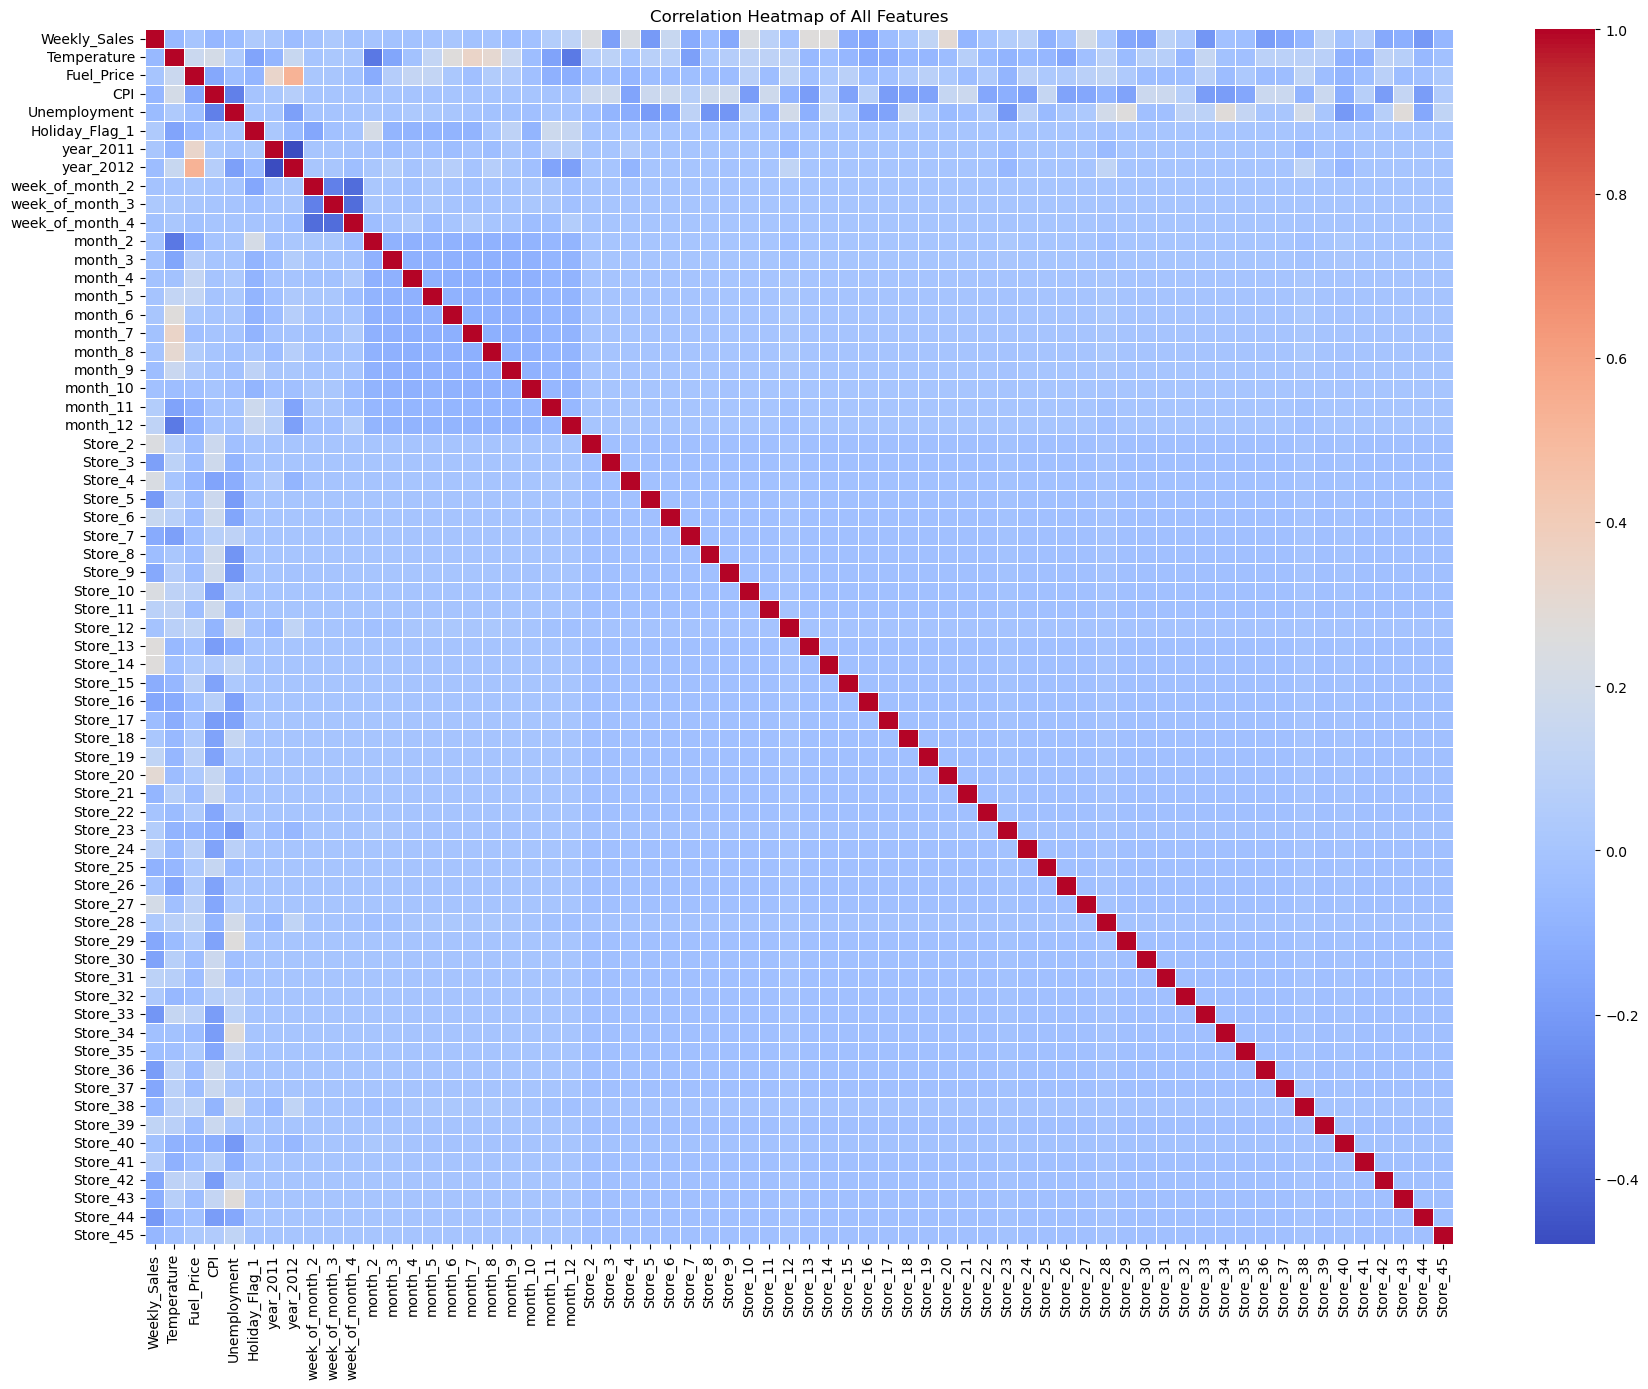

In [20]:
# Plot correlation heatmap of all features
import matplotlib.pyplot as plt
import seaborn as sns

corr = df_encoded.corr()
plt.figure(figsize=(18, 14))
sns.heatmap(corr, cmap='coolwarm', annot=False, fmt='.2f', linewidths=0.5)
plt.title('Correlation Heatmap of All Features')
plt.tight_layout()
plt.show()

In [22]:
# List the 10 feature pairs with highest absolute correlation among all features (excluding self-correlation)
corr_matrix = df_encoded.corr().abs()
corr_unstacked = corr_matrix.where(~np.eye(corr_matrix.shape[0], dtype=bool)).unstack()
sorted_corr = corr_unstacked.sort_values(ascending=False).drop_duplicates()
top10_pairs = sorted_corr.head(10)
print('Top 10 feature pairs with highest absolute correlation (excluding self-correlation):')
for (f1, f2), value in top10_pairs.items():
    print(f'{f1} & {f2}: {value:.4f}')

Top 10 feature pairs with highest absolute correlation (excluding self-correlation):
year_2012 & Fuel_Price: 0.5260
year_2011 & year_2012: 0.4799
week_of_month_2 & week_of_month_4: 0.3650
week_of_month_4 & week_of_month_3: 0.3650
Temperature & month_7: 0.3443
Fuel_Price & year_2011: 0.3325
month_2 & Temperature: 0.3292
month_12 & Temperature: 0.3203
month_8 & Temperature: 0.3084
week_of_month_3 & week_of_month_2: 0.3001


In [24]:
# Define X and y, then display their data types
X = df_encoded.drop(columns=['Weekly_Sales'])
y = df_encoded['Weekly_Sales']
print('X dtypes:')
print(X.dtypes)
print('\ny dtype:')
print(y.dtype)

X dtypes:
Temperature       float64
Fuel_Price        float64
CPI               float64
Unemployment      float64
Holiday_Flag_1      int64
                   ...   
Store_41            int64
Store_42            int64
Store_43            int64
Store_44            int64
Store_45            int64
Length: 65, dtype: object

y dtype:
float64


In [28]:
# Use KFold cross-validation with 5 folds for all models (no train-test split)
from sklearn.model_selection import KFold, cross_val_score, cross_validate
from sklearn.linear_model import LinearRegression, Ridge, Lasso, ElasticNet
from sklearn.preprocessing import PolynomialFeatures
from sklearn.metrics import make_scorer, mean_squared_error, r2_score
import numpy as np

kf = KFold(n_splits=5, shuffle=True, random_state=42)

# Helper scorers
rmse_scorer = make_scorer(lambda y_true, y_pred: np.sqrt(mean_squared_error(y_true, y_pred)), greater_is_better=False)
r2_scorer = make_scorer(r2_score)

# Store results for all models
model_results = {}

# 1. Linear Regression (degree 1)
lr = LinearRegression()
cv_results_lr = cross_validate(lr, X, y, cv=kf, scoring={'rmse': rmse_scorer, 'r2': r2_scorer}, return_estimator=True, return_train_score=True)
model_results['Linear'] = {
    'RMSE_test': -np.mean(cv_results_lr['test_rmse']),
    'RMSE_train': -np.mean(cv_results_lr['train_rmse']),
    'R2_test': np.mean(cv_results_lr['test_r2']),
    'R2_train': np.mean(cv_results_lr['train_r2']),
    'cv_results': cv_results_lr,
    'model': lr
}

# 2. Polynomial Regression (degree 2 & 3)
for deg in [2, 3]:
    poly = PolynomialFeatures(degree=deg, include_bias=False)
    X_poly = poly.fit_transform(X)
    lr_poly = LinearRegression()
    cv_results_poly = cross_validate(lr_poly, X_poly, y, cv=kf, scoring={'rmse': rmse_scorer, 'r2': r2_scorer}, return_estimator=True, return_train_score=True)
    model_results[f'Poly{deg}'] = {
        'RMSE_test': -np.mean(cv_results_poly['test_rmse']),
        'RMSE_train': -np.mean(cv_results_poly['train_rmse']),
        'R2_test': np.mean(cv_results_poly['test_r2']),
        'R2_train': np.mean(cv_results_poly['train_r2']),
        'cv_results': cv_results_poly,
        'model': lr_poly,
        'poly': poly
    }

# 3. Ridge Regression (GridSearchCV with KFold)
from sklearn.model_selection import GridSearchCV
ridge = Ridge()
param_grid_ridge = {'alpha': np.logspace(-3, 3, 30)}
grid_ridge = GridSearchCV(ridge, param_grid_ridge, cv=kf, scoring='neg_mean_squared_error', n_jobs=-1)
grid_ridge.fit(X, y)
best_ridge = grid_ridge.best_estimator_
cv_results_ridge = cross_validate(best_ridge, X, y, cv=kf, scoring={'rmse': rmse_scorer, 'r2': r2_scorer}, return_estimator=True, return_train_score=True)
model_results['Ridge'] = {
    'RMSE_test': -np.mean(cv_results_ridge['test_rmse']),
    'RMSE_train': -np.mean(cv_results_ridge['train_rmse']),
    'R2_test': np.mean(cv_results_ridge['test_r2']),
    'R2_train': np.mean(cv_results_ridge['train_r2']),
    'best_alpha': grid_ridge.best_params_['alpha'],
    'cv_results': cv_results_ridge,
    'model': best_ridge
}

# 4. Lasso Regression (GridSearchCV with KFold, max_iter=1000)
lasso = Lasso(max_iter=1000)
param_grid_lasso = {'alpha': np.logspace(-3, 3, 30)}
grid_lasso = GridSearchCV(lasso, param_grid_lasso, cv=kf, scoring='neg_mean_squared_error', n_jobs=-1)
grid_lasso.fit(X, y)
best_lasso = grid_lasso.best_estimator_
cv_results_lasso = cross_validate(best_lasso, X, y, cv=kf, scoring={'rmse': rmse_scorer, 'r2': r2_scorer}, return_estimator=True, return_train_score=True)
model_results['Lasso'] = {
    'RMSE_test': -np.mean(cv_results_lasso['test_rmse']),
    'RMSE_train': -np.mean(cv_results_lasso['train_rmse']),
    'R2_test': np.mean(cv_results_lasso['test_r2']),
    'R2_train': np.mean(cv_results_lasso['train_r2']),
    'best_alpha': grid_lasso.best_params_['alpha'],
    'cv_results': cv_results_lasso,
    'model': best_lasso
}

# 5. ElasticNet Regression (GridSearchCV with KFold, max_iter=1000)
elastic = ElasticNet(max_iter=1000)
param_grid_elastic = {'alpha': np.logspace(-3, 3, 30), 'l1_ratio': np.linspace(0.1, 0.9, 9)}
grid_elastic = GridSearchCV(elastic, param_grid_elastic, cv=kf, scoring='neg_mean_squared_error', n_jobs=-1)
grid_elastic.fit(X, y)
best_elastic = grid_elastic.best_estimator_
cv_results_elastic = cross_validate(best_elastic, X, y, cv=kf, scoring={'rmse': rmse_scorer, 'r2': r2_scorer}, return_estimator=True, return_train_score=True)
model_results['ElasticNet'] = {
    'RMSE_test': -np.mean(cv_results_elastic['test_rmse']),
    'RMSE_train': -np.mean(cv_results_elastic['train_rmse']),
    'R2_test': np.mean(cv_results_elastic['test_r2']),
    'R2_train': np.mean(cv_results_elastic['train_r2']),
    'best_alpha': grid_elastic.best_params_['alpha'],
    'best_l1_ratio': grid_elastic.best_params_['l1_ratio'],
    'cv_results': cv_results_elastic,
    'model': best_elastic
}

# All model metrics and hyperparameters are now stored in model_results for easy reuse in summary and reporting cells

In [30]:
# Print cross-validated metrics for all models from model_results
print("Model Comparison: Mean RMSE and R2 (5-fold CV)\n")
print(f"{'Model':<12}{'Test RMSE':>12}{'Train RMSE':>12}{'Test R2':>10}{'Train R2':>10}")
for model, res in model_results.items():
    print(f"{model:<12}{res['RMSE_test']:>12.2f}{res['RMSE_train']:>12.2f}{res['R2_test']:>10.4f}{res['R2_train']:>10.4f}")
print("\nHyperparameters:")
for model, res in model_results.items():
    if 'best_alpha' in res:
        print(f"{model}: alpha = {res['best_alpha']}")
    if 'best_l1_ratio' in res:
        print(f"{model}: l1_ratio = {res['best_l1_ratio']}")

Model Comparison: Mean RMSE and R2 (5-fold CV)

Model          Test RMSE  Train RMSE   Test R2  Train R2
Linear         145761.69   143756.08    0.9345    0.9364
Poly2          127895.98    71721.73    0.9481    0.9842
Poly3          359599.18        0.00    0.5945    1.0000
Ridge          145731.74   143763.13    0.9346    0.9364
Lasso          145730.29   143768.44    0.9346    0.9363
ElasticNet     145875.55   143937.39    0.9344    0.9362

Hyperparameters:
Ridge: alpha = 0.0727895384398315
Lasso: alpha = 13.738237958832638
ElasticNet: alpha = 0.001
ElasticNet: l1_ratio = 0.9


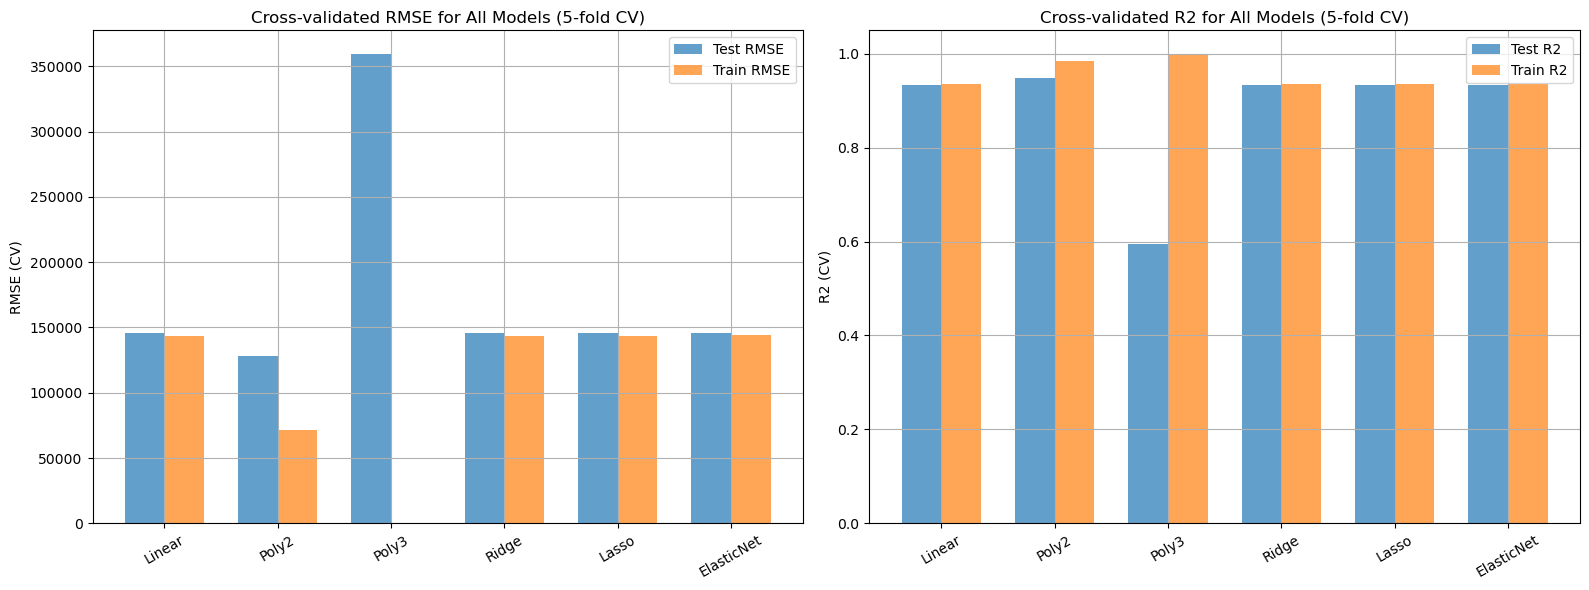

In [31]:
# Visualize cross-validated RMSE and R2 for all models (train and test)
import matplotlib.pyplot as plt
models = list(model_results.keys())
rmse_test_vals = [model_results[m]['RMSE_test'] for m in models]
rmse_train_vals = [model_results[m]['RMSE_train'] for m in models]
r2_test_vals = [model_results[m]['R2_test'] for m in models]
r2_train_vals = [model_results[m]['R2_train'] for m in models]

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16,6))

# RMSE plot
width = 0.35
x = range(len(models))
ax1.bar([i - width/2 for i in x], rmse_test_vals, width=width, label='Test RMSE', color='tab:blue', alpha=0.7)
ax1.bar([i + width/2 for i in x], rmse_train_vals, width=width, label='Train RMSE', color='tab:orange', alpha=0.7)
ax1.set_xticks(x)
ax1.set_xticklabels(models, rotation=30)
ax1.set_ylabel('RMSE (CV)')
ax1.set_title('Cross-validated RMSE for All Models (5-fold CV)')
ax1.legend()
ax1.grid(True)

# R2 plot
ax2.bar([i - width/2 for i in x], r2_test_vals, width=width, label='Test R2', color='tab:blue', alpha=0.7)
ax2.bar([i + width/2 for i in x], r2_train_vals, width=width, label='Train R2', color='tab:orange', alpha=0.7)
ax2.set_xticks(x)
ax2.set_xticklabels(models, rotation=30)
ax2.set_ylabel('R2 (CV)')
ax2.set_title('Cross-validated R2 for All Models (5-fold CV)')
ax2.legend()
ax2.grid(True)

plt.tight_layout()
plt.show()

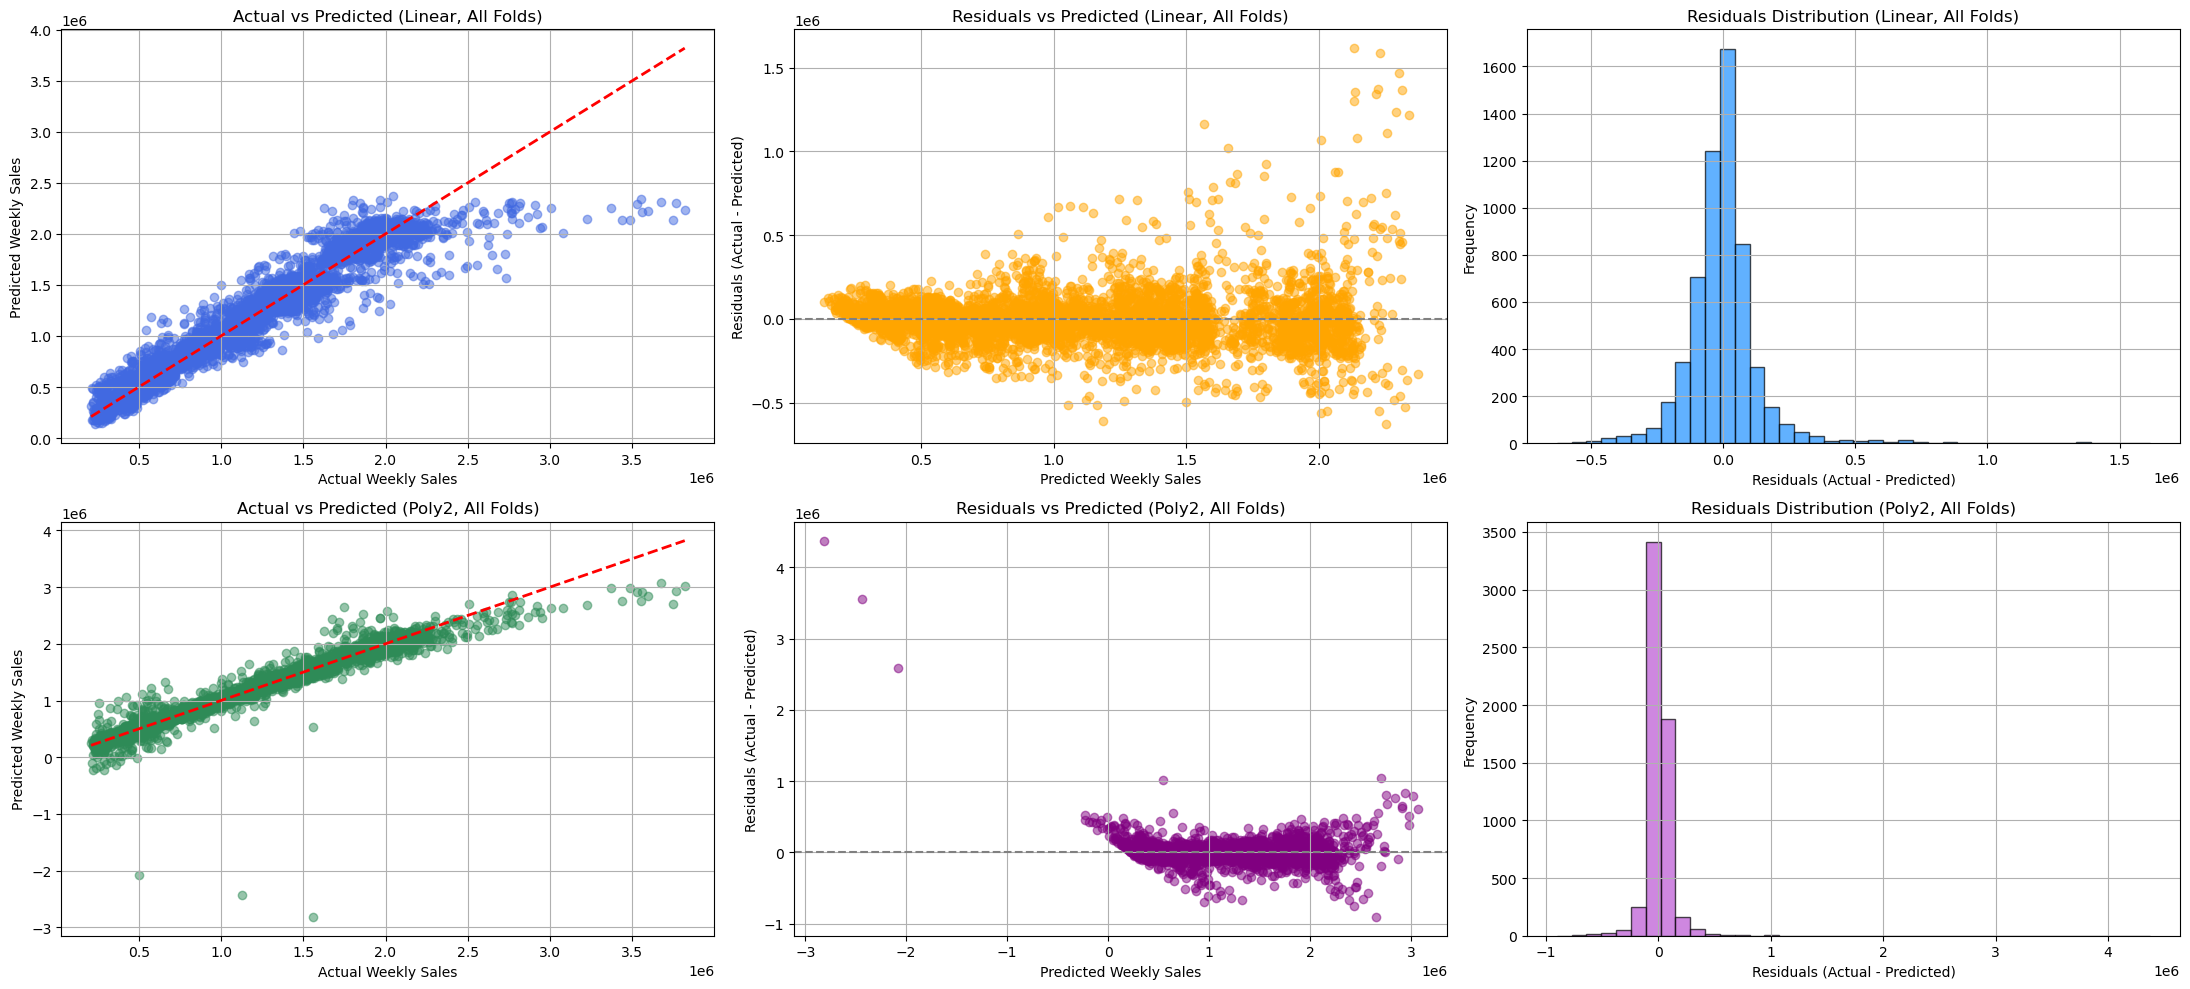

In [36]:
# Diagnostics: Average Actual vs Predicted and Residuals for Linear and Poly2 Regression (all 5 folds)
import matplotlib.pyplot as plt
import numpy as np

# Linear Regression (all folds)
lr_cv = model_results['Linear']['cv_results']
y_true_all = []
y_pred_all = []
residuals_all = []
for i in range(5):
    test_indices = list(KFold(n_splits=5, shuffle=True, random_state=42).split(X))[i][1]
    X_test_fold = X.iloc[test_indices]
    y_test_fold = y.iloc[test_indices]
    estimator_lr = lr_cv['estimator'][i]
    y_pred_fold_lr = estimator_lr.predict(X_test_fold)
    y_true_all.append(y_test_fold)
    y_pred_all.append(y_pred_fold_lr)
    residuals_all.append(y_test_fold - y_pred_fold_lr)
y_true_all = np.concatenate([arr.values for arr in y_true_all])
y_pred_all = np.concatenate([arr for arr in y_pred_all])
residuals_all = np.concatenate([arr.values for arr in residuals_all])

# Poly2 Regression (all folds)
poly2_cv = model_results['Poly2']['cv_results']
poly2 = model_results['Poly2']['poly']
X_poly2 = poly2.transform(X)
y_true_poly2 = []
y_pred_poly2 = []
residuals_poly2 = []
for i in range(5):
    test_indices = list(KFold(n_splits=5, shuffle=True, random_state=42).split(X_poly2))[i][1]
    X_test_fold_poly2 = X_poly2[test_indices]
    y_test_fold = y.iloc[test_indices]
    estimator_poly2 = poly2_cv['estimator'][i]
    y_pred_fold_poly2 = estimator_poly2.predict(X_test_fold_poly2)
    y_true_poly2.append(y_test_fold)
    y_pred_poly2.append(y_pred_fold_poly2)
    residuals_poly2.append(y_test_fold - y_pred_fold_poly2)
y_true_poly2 = np.concatenate([arr.values for arr in y_true_poly2])
y_pred_poly2 = np.concatenate([arr for arr in y_pred_poly2])
residuals_poly2 = np.concatenate([arr.values for arr in residuals_poly2])

fig, axs = plt.subplots(2, 3, figsize=(22, 10))

# Linear: Actual vs Predicted (all folds)
axs[0,0].scatter(y_true_all, y_pred_all, alpha=0.5, color='royalblue')
axs[0,0].plot([y_true_all.min(), y_true_all.max()], [y_true_all.min(), y_true_all.max()], 'r--', lw=2)
axs[0,0].set_xlabel('Actual Weekly Sales')
axs[0,0].set_ylabel('Predicted Weekly Sales')
axs[0,0].set_title('Actual vs Predicted (Linear, All Folds)')
axs[0,0].grid(True)

# Linear: Residuals (all folds)
axs[0,1].scatter(y_pred_all, residuals_all, alpha=0.5, color='orange')
axs[0,1].axhline(0, color='gray', linestyle='--')
axs[0,1].set_xlabel('Predicted Weekly Sales')
axs[0,1].set_ylabel('Residuals (Actual - Predicted)')
axs[0,1].set_title('Residuals vs Predicted (Linear, All Folds)')
axs[0,1].grid(True)

# Linear: Residuals Histogram
axs[0,2].hist(residuals_all, bins=40, color='dodgerblue', alpha=0.7, edgecolor='black')
axs[0,2].set_xlabel('Residuals (Actual - Predicted)')
axs[0,2].set_ylabel('Frequency')
axs[0,2].set_title('Residuals Distribution (Linear, All Folds)')
axs[0,2].grid(True)

# Poly2: Actual vs Predicted (all folds)
axs[1,0].scatter(y_true_poly2, y_pred_poly2, alpha=0.5, color='seagreen')
axs[1,0].plot([y_true_poly2.min(), y_true_poly2.max()], [y_true_poly2.min(), y_true_poly2.max()], 'r--', lw=2)
axs[1,0].set_xlabel('Actual Weekly Sales')
axs[1,0].set_ylabel('Predicted Weekly Sales')
axs[1,0].set_title('Actual vs Predicted (Poly2, All Folds)')
axs[1,0].grid(True)

# Poly2: Residuals (all folds)
axs[1,1].scatter(y_pred_poly2, residuals_poly2, alpha=0.5, color='purple')
axs[1,1].axhline(0, color='gray', linestyle='--')
axs[1,1].set_xlabel('Predicted Weekly Sales')
axs[1,1].set_ylabel('Residuals (Actual - Predicted)')
axs[1,1].set_title('Residuals vs Predicted (Poly2, All Folds)')
axs[1,1].grid(True)

# Poly2: Residuals Histogram
axs[1,2].hist(residuals_poly2, bins=40, color='mediumorchid', alpha=0.7, edgecolor='black')
axs[1,2].set_xlabel('Residuals (Actual - Predicted)')
axs[1,2].set_ylabel('Frequency')
axs[1,2].set_title('Residuals Distribution (Poly2, All Folds)')
axs[1,2].grid(True)

plt.tight_layout()
plt.show()

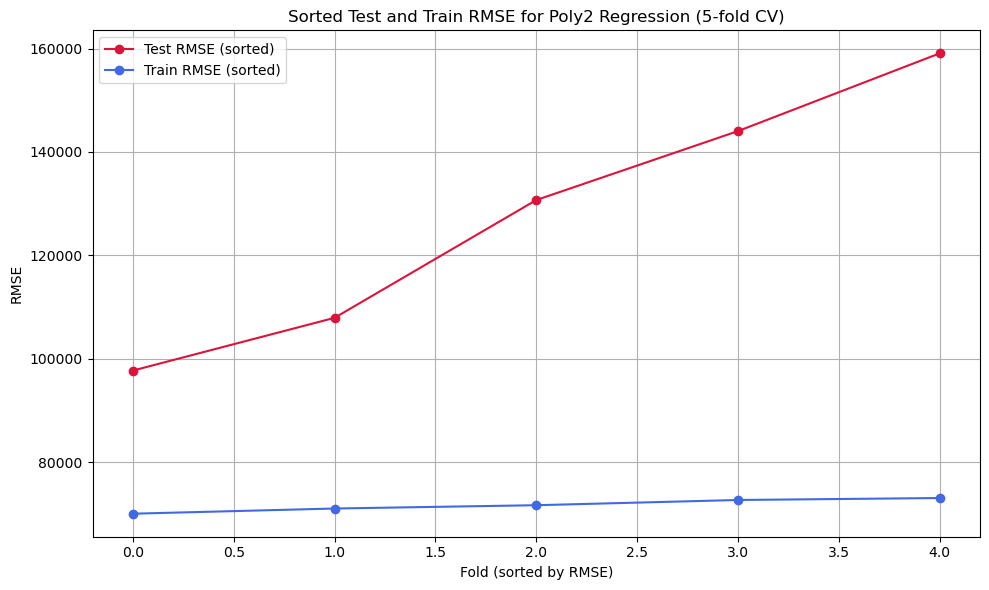

In [37]:
# Plot sorted test and train RMSE for Poly2 regression across all 5 folds
import matplotlib.pyplot as plt
import numpy as np

# Get Poly2 cross-validation results
poly2_cv = model_results['Poly2']['cv_results']
test_rmse_folds = -poly2_cv['test_rmse']  # negative because scorer is neg RMSE
train_rmse_folds = -poly2_cv['train_rmse']

# Sort RMSE values for visualization
sorted_test_rmse = np.sort(test_rmse_folds)
sorted_train_rmse = np.sort(train_rmse_folds)

plt.figure(figsize=(10,6))
plt.plot(sorted_test_rmse, marker='o', label='Test RMSE (sorted)', color='crimson')
plt.plot(sorted_train_rmse, marker='o', label='Train RMSE (sorted)', color='royalblue')
plt.xlabel('Fold (sorted by RMSE)')
plt.ylabel('RMSE')
plt.title('Sorted Test and Train RMSE for Poly2 Regression (5-fold CV)')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

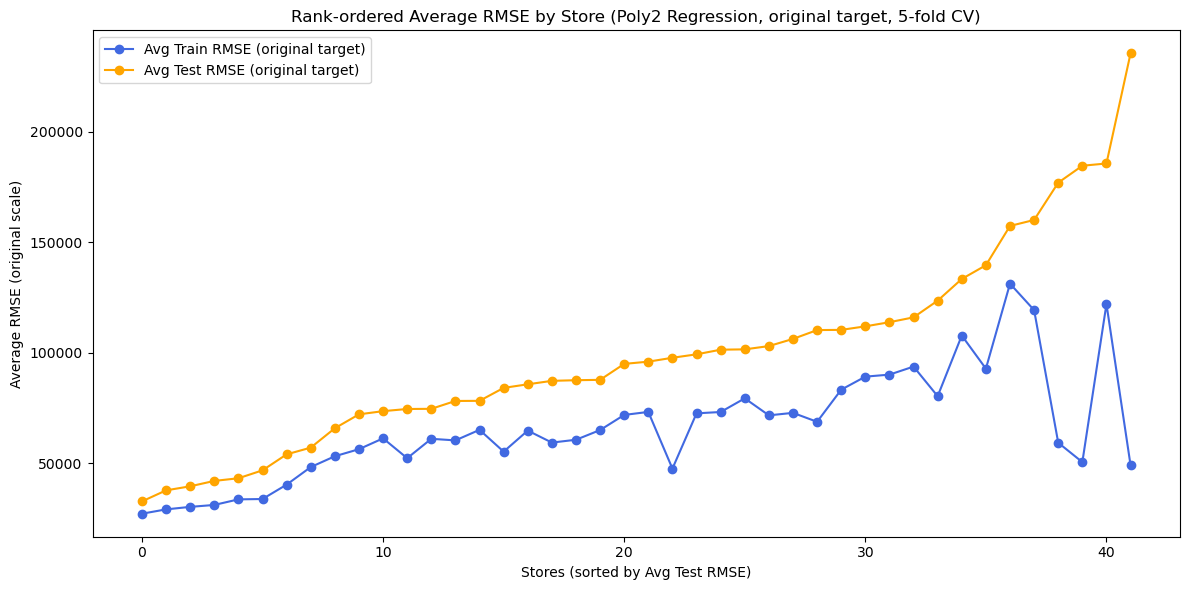

In [43]:
# Correct cross-validated per-store RMSE for Poly2 regression (5-fold CV, original Weekly_Sales)
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# Get Poly2 predictions for all samples (cross-validated)
poly2_cv = model_results['Poly2']['cv_results']
poly2 = model_results['Poly2']['poly']
X_poly2 = poly2.transform(X)

# Prepare per-fold per-store RMSE lists
n_folds = 5
kf = KFold(n_splits=n_folds, shuffle=True, random_state=42)

store_ids = sorted(original_df['Store'].unique())
store_rmse_train = {sid: [] for sid in store_ids}
store_rmse_test = {sid: [] for sid in store_ids}

for fold_idx, (train_indices, test_indices) in enumerate(kf.split(X_poly2)):
    # Train predictions
    estimator_poly2 = poly2_cv['estimator'][fold_idx]
    X_train_fold_poly2 = X_poly2[train_indices]
    y_train_pred_fold_poly2 = estimator_poly2.predict(X_train_fold_poly2)
    y_train_fold = y.iloc[train_indices].values
    train_store_fold = original_df.iloc[train_indices]['Store'].values
    # Test predictions
    X_test_fold_poly2 = X_poly2[test_indices]
    y_test_pred_fold_poly2 = estimator_poly2.predict(X_test_fold_poly2)
    y_test_fold = y.iloc[test_indices].values
    test_store_fold = original_df.iloc[test_indices]['Store'].values
    # For each store, calculate RMSE for train and test in this fold
    for sid in store_ids:
        # Train
        train_mask = train_store_fold == sid
        if np.any(train_mask):
            rmse_train = np.sqrt(np.mean((y_train_fold[train_mask] - y_train_pred_fold_poly2[train_mask]) ** 2))
            store_rmse_train[sid].append(rmse_train)
        # Test
        test_mask = test_store_fold == sid
        if np.any(test_mask):
            rmse_test = np.sqrt(np.mean((y_test_fold[test_mask] - y_test_pred_fold_poly2[test_mask]) ** 2))
            store_rmse_test[sid].append(rmse_test)

# Average RMSE across folds for each store
avg_rmse_train = np.array([np.mean(store_rmse_train[sid]) for sid in store_ids])
avg_rmse_test = np.array([np.mean(store_rmse_test[sid]) for sid in store_ids])

# Sort stores by average test RMSE
sort_idx = np.argsort(avg_rmse_test)
sorted_stores = np.array(store_ids)[sort_idx]
sorted_train_rmse = avg_rmse_train[sort_idx]
sorted_test_rmse = avg_rmse_test[sort_idx]

plt.figure(figsize=(12,6))
plt.plot(range(len(sorted_stores)), sorted_train_rmse, marker='o', color='royalblue', label='Avg Train RMSE (original target)')
plt.plot(range(len(sorted_stores)), sorted_test_rmse, marker='o', color='orange', label='Avg Test RMSE (original target)')
plt.title('Rank-ordered Average RMSE by Store (Poly2 Regression, original target, 5-fold CV)')
plt.xlabel('Stores (sorted by Avg Test RMSE)')
plt.ylabel('Average RMSE (original scale)')
plt.legend()
plt.tight_layout()
plt.show()

In [46]:
# Calculate VIF for all features in the regression model (not affected by cross-validation)
import pandas as pd
import statsmodels.api as sm
from statsmodels.stats.outliers_influence import variance_inflation_factor

X_vif = X.copy()
X_vif = sm.add_constant(X_vif)

vif_data = pd.DataFrame()
vif_data['feature'] = X_vif.columns
vif_data['VIF'] = [variance_inflation_factor(X_vif.values, i) for i in range(X_vif.shape[1])]

vif_data_sorted = vif_data.sort_values('VIF', ascending=False).reset_index(drop=True)

print('Variance Inflation Factor (VIF) for all features (sorted high to low):')
display(vif_data_sorted)

Variance Inflation Factor (VIF) for all features (sorted high to low):


,feature,VIF
0,CPI,1173.937759
1,const,1011.291562
2,Store_34,142.494774
3,Store_17,141.927188
4,Store_44,141.592518
...,...,...
61,Store_2,1.953676
62,week_of_month_4,1.689784
63,week_of_month_2,1.627037
64,week_of_month_3,1.591667


### RFE for Linear Regression: Feature Selection and RMSE Analysis

This cell applies Recursive Feature Elimination (RFE) with linear regression and 5-fold cross-validation. For each possible number of features, the model is trained and evaluated, and the mean train and test RMSE are plotted.

- **Purpose:** Identify the optimal number of features that minimize test RMSE, helping to avoid overfitting and improve generalization.
- **Interpretation:**
    - If test RMSE decreases as features are removed, it may indicate that some features are redundant or introduce noise.
    - A large gap between train and test RMSE suggests overfitting.
    - The best feature count is typically where test RMSE is lowest and the train-test gap is minimal.

Use this plot to guide feature selection for linear regression models.

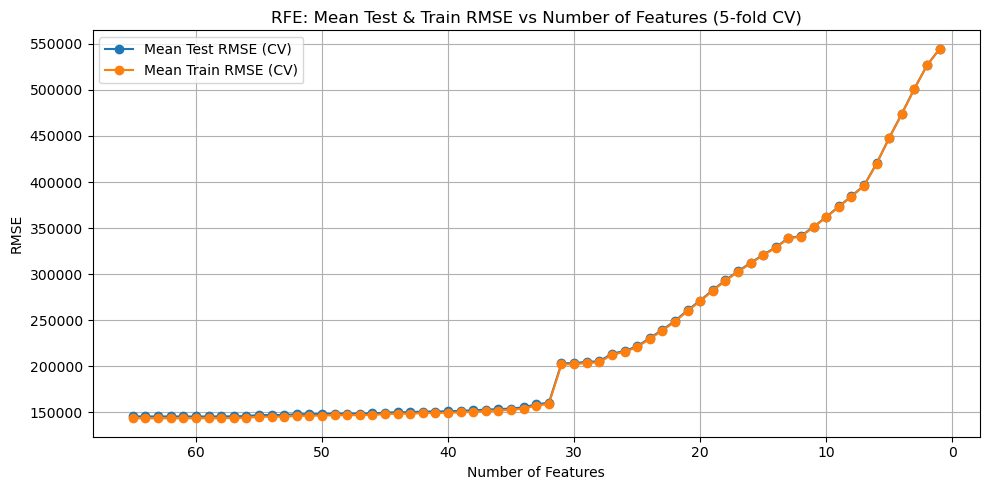

In [49]:
# RFE with KFold cross-validation: Plot mean test and train RMSE vs number of features
from sklearn.feature_selection import RFE
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import KFold
import matplotlib.pyplot as plt
import numpy as np

n_features = X.shape[1]
rmse_test_list = []
rmse_train_list = []
num_features_list = []
kf = KFold(n_splits=5, shuffle=True, random_state=42)

for n in range(n_features, 0, -1):
    lr = LinearRegression()
    rfe = RFE(lr, n_features_to_select=n)
    X_rfe = rfe.fit_transform(X, y)
    rmse_test_fold = []
    rmse_train_fold = []
    for train_idx, test_idx in kf.split(X_rfe):
        X_train_rfe, X_test_rfe = X_rfe[train_idx], X_rfe[test_idx]
        y_train_rfe, y_test_rfe = y.iloc[train_idx], y.iloc[test_idx]
        lr.fit(X_train_rfe, y_train_rfe)
        y_pred_train_rfe = lr.predict(X_train_rfe)
        y_pred_test_rfe = lr.predict(X_test_rfe)
        rmse_train_fold.append(np.sqrt(mean_squared_error(y_train_rfe, y_pred_train_rfe)))
        rmse_test_fold.append(np.sqrt(mean_squared_error(y_test_rfe, y_pred_test_rfe)))
    rmse_test_list.append(np.mean(rmse_test_fold))
    rmse_train_list.append(np.mean(rmse_train_fold))
    num_features_list.append(n)

plt.figure(figsize=(10,5))
plt.plot(num_features_list, rmse_test_list, marker='o', label='Mean Test RMSE (CV)')
plt.plot(num_features_list, rmse_train_list, marker='o', label='Mean Train RMSE (CV)')
plt.xlabel('Number of Features')
plt.ylabel('RMSE')
plt.title('RFE: Mean Test & Train RMSE vs Number of Features (5-fold CV)')
plt.gca().invert_xaxis()
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()

In [50]:
# Find optimal number of features and list selected features for linear RFE (lowest test RMSE)
from sklearn.feature_selection import RFE
from sklearn.linear_model import LinearRegression
import numpy as np

n_features = X.shape[1]
kf = KFold(n_splits=5, shuffle=True, random_state=42)

# Store mean test RMSE for each feature count and RFE selector
rmse_test_list = []
rfe_selectors = []

for n in range(n_features, 0, -1):
    lr = LinearRegression()
    rfe = RFE(lr, n_features_to_select=n)
    X_rfe = rfe.fit_transform(X, y)
    rmse_test_fold = []
    for train_idx, test_idx in kf.split(X_rfe):
        X_train_rfe, X_test_rfe = X_rfe[train_idx], X_rfe[test_idx]
        y_train_rfe, y_test_rfe = y.iloc[train_idx], y.iloc[test_idx]
        lr.fit(X_train_rfe, y_train_rfe)
        y_pred_test_rfe = lr.predict(X_test_rfe)
        rmse_test_fold.append(np.sqrt(mean_squared_error(y_test_rfe, y_pred_test_rfe)))
    rmse_test_list.append(np.mean(rmse_test_fold))
    rfe_selectors.append(rfe)

# Find optimal number of features (lowest test RMSE)
min_rmse_idx = np.argmin(rmse_test_list)
optimal_n = n_features - min_rmse_idx

optimal_rfe = rfe_selectors[min_rmse_idx]
selected_mask = optimal_rfe.support_
selected_features = X.columns[selected_mask]

print(f"Optimal number of features: {optimal_n}")
print(f"Lowest mean test RMSE: {rmse_test_list[min_rmse_idx]:.2f}")
print("Selected features:")
for feat in selected_features:
    print(f"- {feat}")

Optimal number of features: 59
Lowest mean test RMSE: 145662.52
Selected features:
- Temperature
- CPI
- Unemployment
- Holiday_Flag_1
- year_2011
- year_2012
- week_of_month_3
- week_of_month_4
- month_2
- month_3
- month_7
- month_8
- month_9
- month_10
- month_11
- month_12
- Store_2
- Store_3
- Store_4
- Store_5
- Store_6
- Store_7
- Store_8
- Store_9
- Store_10
- Store_11
- Store_12
- Store_13
- Store_14
- Store_15
- Store_16
- Store_17
- Store_18
- Store_19
- Store_20
- Store_21
- Store_22
- Store_23
- Store_24
- Store_25
- Store_26
- Store_27
- Store_28
- Store_29
- Store_30
- Store_31
- Store_32
- Store_33
- Store_35
- Store_36
- Store_37
- Store_38
- Store_39
- Store_40
- Store_41
- Store_42
- Store_43
- Store_44
- Store_45


In [51]:
# Print dropped (unselected) features for optimal linear RFE
dropped_features = X.columns[~selected_mask]
print("Dropped features:")
for feat in dropped_features:
    print(f"- {feat}")

Dropped features:
- Fuel_Price
- week_of_month_2
- month_4
- month_5
- month_6
- Store_34
